# Create the graph from the book example

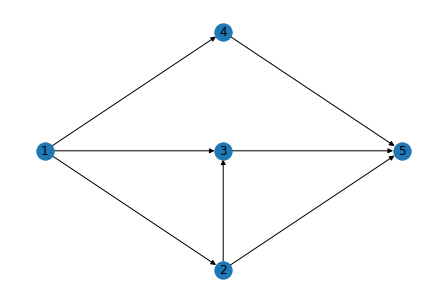

In [37]:
from math import inf
import matplotlib.pyplot as plt
import networkx as nx
from typing import Any, Optional

G = nx.DiGraph()

b = [40, 50, 0, -30, -60]
edges = [(1,2), (1,3), (1,4), (2,3), (2,5), (3,5), (4,5)]
edge_data = [(3, inf), (7, 10), (5, 35), (2, 60), (1, 30), (8, inf), (4, inf)]

G.add_nodes_from(zip(range(1, 6), ({"b": b[i]} for i in range(5))))
G.add_edges_from(edges)
for edge, data in zip(edges, edge_data):
    from_, to_ = edge
    cost, cap = data
    G[from_][to_]["cost"] = cost
    G[from_][to_]["cap"] = cap
    G[from_][to_]["flow"] = 0
    
nx.draw_shell(G, nlist=[[3], [1, 2, 5, 4]], with_labels=True)

# Create Network Simplex functions
Steps:
1. Find a rooted feasible spanning tree with $m-1$ basic arcs
   - Check if $\sum b_i =0$. If not add dummy nodes and associated dummy arcs
   - Designate a demand node ($b_i < 0$>) as a root node and create a rooted arc from it
   - Create a feasible spanning tree. Begin with the end nodes and proceed toward the rooted node. Assign flows to arcs so that at each node the net flow is $b_i$


In [38]:
def find_feasible_spanning_tree(graph: nx.DiGraph):
    # This is assuming the graph is the book example, and uses their given 
    # spanning tree.
    graph[1][3]["flow"] = 10
    graph[1][4]["flow"] = 30
    graph[2][3]["flow"] = 50
    graph[3][5]["flow"] = 60
    graph.add_edge(5, "root")
    tree = [(1,3), (1,4), (2,3), (3,5), (5,"root")]
    print(f"Feasible Spanning Tree: {tree}")
    return tree

# basic_arcs = find_feasible_spanning_tree(G)
# print(basic_arcs)

2. Compute the node potentials ($u_i$ or the dual variables). Set the rooted node to 0 and then use $u_i - u_j = c_{ij}$ to iteratively backtrack the other values.


In [39]:
def compute_duals(graph: nx.DiGraph, basic_arcs: list[tuple[Any, Any]]):
    root = basic_arcs[-1][0]
    duals: dict[Any, float] = {}
    duals[root] = 0
    
    queue = [root]
    basic_arcs_set = set(basic_arcs)
    
    while len(duals) < len(graph) - 1:
        for node in queue:
            for prev in graph.pred[node]:
                if (prev, node) not in basic_arcs_set:
                    continue
                if prev not in duals:
                    duals[prev] = graph.edges[prev, node]["cost"] + duals[node]
                    queue.append(prev)  # intentionally mutating queue during iteration
            
        for node in queue:
            for post in graph.succ[node]:
                if (node, post) not in basic_arcs_set:
                    continue
                if post == "root":
                    continue
                if post not in duals:
                    duals[post] = duals[node] - graph.edges[node, post]["cost"]
                    queue.append(post)  # intentionally mutating queue during iteration
    
    print(f"Duals: {duals}")
    return duals
                
    
    
# duals = compute_duals(G, basic_arcs)
# print(duals)

3. Compute the reduced costs $\bar{c}_{ij} = u_i - u_j - c_{ij}$ for all non-basic (un-used or at capacity) arcs. Check optimality ($x_{ij}=0 \Rightarrow \bar{c}_{ij} \leq 0, x_{ij} = U_{ij} \Rightarrow \bar{c}_{ij}$). If not optimal, choose an entering arc that most violates either optimality condition.


In [40]:
def compute_reduced_costs(graph: nx.DiGraph, basic_arcs: list[tuple[Any, Any]], duals: dict[Any, float]):
    basic_arcs_set = set(basic_arcs)
    reduced_costs: dict[tuple[Any, Any], float] = {}
    for edge in graph.edges:
        if edge not in basic_arcs_set:
            u_from, u_to = duals[edge[0]], duals[edge[1]]
            cost_from_to = graph.edges[edge]["cost"]
            reduced_costs[edge] = u_from - u_to - cost_from_to
    
    print(f"Reduced Costs: {reduced_costs}")
    return reduced_costs

# reduced_costs = compute_reduced_costs(G, basic_arcs, duals)

def optimality_violations(graph: nx.DiGraph, reduced_costs: dict[tuple[Any, Any], float]):
    violations = {edge: 0.0 for edge in reduced_costs}
    for edge in reduced_costs:
        if graph.edges[edge]["flow"] == 0 and reduced_costs[edge] > 0:
            violations[edge] = reduced_costs[edge]
        if graph.edges[edge]["flow"] == graph.edges[edge]["cap"] and reduced_costs[edge] < 0:
            violations[edge] = -reduced_costs[edge]
    
    print(f"Violations: {violations}")
    return violations

# violations = optimality_violations(G, reduced_costs)
# print(violations)

def is_optimal(violations: dict[tuple[Any, Any], float], epsilon: float = 1e-6):
    is_optimal_ = all(abs(v) <= epsilon for v in violations.values())
    print(f"Is optimal? {is_optimal_}")
    return is_optimal_

# print("Is optimal? " + str(is_optimal(violations)))

def entering_arc(violations: dict[tuple[Any, Any], float]):
    max_violation = max(violations.values())
    for edge, violation in violations.items():
        if violation == max_violation:
            print(f"Entering Arc: {edge}")
            return edge
    else:
        raise ValueError("No entering arc was calculated.")

# entering_edge = entering_arc(violations)
# print(entering_edge)

4. Form a unique cycle by adding the entering arc. Determine the maximum amount of $\Delta$ (either increase or decrease flow) without violating constraints. The leaving arc is the one that "hits" a constraint with this $\Delta$.


In [41]:
def find_cycle(entering_arc: tuple[Any, Any], basic_arcs: list[tuple[Any, Any]]):
    spanning_tree = nx.Graph()
    spanning_tree.add_edges_from(basic_arcs)
    paths = nx.algorithms.shortest_simple_paths(spanning_tree, *entering_arc)
    try:
        path = next(paths)
    except GeneratorExit as err:
        raise ValueError("Basic arcs do not form a spanning tree.") from err
    
    undirected_path: list[tuple[Any, Any]] = list(zip(path, path[1:]))
    basic_arc_set = set(basic_arcs)
    directed_path = [
        arc if arc in basic_arc_set else tuple(reversed(arc))
        for arc in undirected_path
    ]
    directed_path.append(entering_arc)
    
    print(f"Cycle: {directed_path}")
    return directed_path
    
# cycle = find_cycle(entering_edge, basic_arcs)
# print(cycle)

def find_deltas(graph: nx.DiGraph, cycle: list[tuple[Any, Any]]):
    signed_deltas: dict[tuple[Any, Any], float] = {}
    
    entering_arc = cycle[-1]
    entering_flow = graph.edges[entering_arc]["flow"]
    node = entering_arc[0]
    entering_is_increasing = entering_flow == 0
    sign = 1 if entering_is_increasing else -1
        
    for cycle_arc in cycle:
        cap = graph.edges[cycle_arc]["cap"]
        flow = graph.edges[cycle_arc]["flow"]
        
        if node == cycle_arc[1]:
            # Same direction as entering edge
            delta = cap - flow if entering_is_increasing else flow
            signed_deltas[cycle_arc] = sign * delta
            node = cycle_arc[0]
        elif node == cycle_arc[0]:
            # Opposite direction as entering edge
            delta = flow if entering_is_increasing else cap - flow
            signed_deltas[cycle_arc] = -sign * delta
            node = cycle_arc[1]
        else:
            raise ValueError(
                "Cycle was not given in 'traversal' order, "
                "or is otherwise incorrect."
            )
    
    print(f"Deltas: {signed_deltas}")
    return signed_deltas

# deltas = find_deltas(G, cycle)
# print(deltas)

5. Find the new feasible spanning tree by adjusting the flows in the cycle so that flow conservation is maintained (i.e., add or subtract $\Delta$ appropriately). Go back to 2.

In [42]:
def update_spanning_tree(
    graph: nx.DiGraph, 
    basic_arcs: list[tuple[Any, Any]], 
    cycle: list[tuple[Any, Any]],
    deltas: dict[tuple[Any, Any], float],
):
    sign = lambda x: 1 if x >= 0 else -1
    signs = {arc: sign(delta) for arc, delta in deltas.items()}
    delta = min(abs(delta) for delta in deltas.values())
    
    for arc in cycle[:-1]:
        multiplier = signs[arc]
        graph.edges[arc]["flow"] += multiplier * delta
        flow = graph.edges[arc]["flow"]
        if flow == 0 or flow == graph.edges[arc]["cap"]:
            basic_arcs.remove(arc)
    
    entering_arc = cycle[-1]
    entering_multiplier = signs[entering_arc]
    graph.edges[entering_arc]["flow"] += entering_multiplier * delta
    entering_flow = graph.edges[entering_arc]["flow"]
    if entering_flow != 0 and entering_flow != graph.edges[entering_arc]["cap"]:
        basic_arcs.insert(-1, entering_arc)
    
    print(f"Updated Spanning Tree: {basic_arcs}")
    return basic_arcs

# updated_basic_arcs = update_spanning_tree(G, basic_arcs, cycle, deltas)
# print(updated_basic_arcs)

# Perform network simplex
Steps:
1. Find a rooted feasible spanning tree with $m-1$ basic arcs
   - Check if $\sum b_i =0$. If not add dummy nodes and associated dummy arcs
   - Designate a demand node ($b_i < 0$>) as a root node and create a rooted arc from it
   - Create a feasible spanning tree. Begin with the end nodes and proceed toward the rooted node. Assign flows to arcs so that at each node the net flow is $b_i$
2. Compute the node potentials ($u_i$ or the dual variables). Set the rooted node to 0 and then use $u_i - u_j = c_{ij}$ to iteratively backtrack the other values.
3. Compute the reduced costs $\bar{c}_{ij} = u_i - u_j - c_{ij}$ for all non-basic (un-used or at capacity) arcs. Check optimality ($x_{ij}=0 \Rightarrow \bar{c}_{ij} \leq 0, x_{ij} = U_{ij} \Rightarrow \bar{c}_{ij}$). If not optimal, choose an entering arc that most violates either optimality condition.
4. Form a unique cycle by adding the entering arc. Determine the maximum amount of $\Delta$ (either increase or decrease flow) without violating constraints. The leaving arc is the one that "hits" a constraint with this $\Delta$.
5. Find the new feasible spanning tree by adjusting the flows in the cycle so that flow conservation is maintained (i.e., add or subtract $\Delta$ appropriately). Go back to 2.

In [43]:
def update_basis(
    graph: nx.DiGraph, 
    basic_arcs: list[tuple[Any, Any]], 
    reduced_costs: Optional[dict[tuple[Any, Any], float]] = None
):
    if reduced_costs is None:
        # Step 2 if not already done
        duals = compute_duals(graph, basic_arcs)
        # Step 3(a) if not already done
        reduced_costs = compute_reduced_costs(graph, basic_arcs, duals)
    # Step 3(b)
    violations = optimality_violations(graph, reduced_costs)
    if is_optimal(violations):
        return basic_arcs, reduced_costs
    entering_edge = entering_arc(violations)
    # Step 4
    cycle = find_cycle(entering_edge, basic_arcs)
    deltas = find_deltas(graph, cycle)
    # Step 5
    basic_arcs = update_spanning_tree(graph, basic_arcs, cycle, deltas)
    # Step 2
    duals = compute_duals(graph, basic_arcs)
    # Step 3(a)
    reduced_costs = compute_reduced_costs(graph, basic_arcs, duals)
    
    return basic_arcs, reduced_costs
    

def calc_cost(graph: nx.DiGraph):
    cost = 0
    for data in graph.edges.values():
        cost += data.get("flow", 0) * data.get("cost", 0)
    
    print(f"Cost: {cost}")
    return cost

def network_simplex(graph: nx.DiGraph):
    basic_arcs = find_feasible_spanning_tree(graph)
    print([((f_, t_), data) for f_, t_, data in G.edges.data("flow")])
    cost = calc_cost(graph)
    print("###############################################################")
    
    basic_arcs, reduced_costs = update_basis(graph, basic_arcs)
    print([((f_, t_), data) for f_, t_, data in G.edges.data("flow")])
    cost = calc_cost(graph)
    print("###############################################################")
    
    while not is_optimal(optimality_violations(graph, reduced_costs)):
        basic_arcs, reduced_costs = update_basis(graph, basic_arcs)
        print([((f_, t_), data) for f_, t_, data in G.edges.data("flow")])
        cost = calc_cost(graph)
        print("###############################################################")
    
    print([((f_, t_), data) for f_, t_, data in G.edges.data("flow")])
    cost = calc_cost(graph)
    print("###############################################################")
    return basic_arcs, cost
    
solution, cost = network_simplex(G)
# print(solution)
# print(cost)


Feasible Spanning Tree: [(1, 3), (1, 4), (2, 3), (3, 5), (5, 'root')]
[((1, 2), 0), ((1, 3), 10), ((1, 4), 30), ((2, 3), 50), ((2, 5), 0), ((3, 5), 60), ((4, 5), 0), ((5, 'root'), None)]
Cost: 800
###############################################################
Duals: {5: 0, 3: 8, 1: 15, 2: 10, 4: 10}
Reduced Costs: {(1, 2): 2, (2, 5): 9, (4, 5): 6}
Violations: {(1, 2): 2, (2, 5): 9, (4, 5): 6}
Is optimal? False
Entering Arc: (2, 5)
Cycle: [(2, 3), (3, 5), (2, 5)]
Deltas: {(2, 3): -50, (3, 5): -60, (2, 5): 30}
Updated Spanning Tree: [(1, 3), (1, 4), (2, 3), (3, 5), (5, 'root')]
Duals: {5: 0, 3: 8, 1: 15, 2: 10, 4: 10}
Reduced Costs: {(1, 2): 2, (2, 5): 9, (4, 5): 6}
[((1, 2), 0), ((1, 3), 10), ((1, 4), 30), ((2, 3), 20), ((2, 5), 30), ((3, 5), 30), ((4, 5), 0), ((5, 'root'), None)]
Cost: 530
###############################################################
Violations: {(1, 2): 2, (2, 5): 0.0, (4, 5): 6}
Is optimal? False
Duals: {5: 0, 3: 8, 1: 15, 2: 10, 4: 10}
Reduced Costs: {(1, 2): 2, 